# Predicting NHL Injuries
This notebook contains the code for training and testing my model as well as some visualizations and exploratory data analysis I used to draw additional conclusions. All data is loaded from pickle files **merged_data_df.pk**, **merged_by_player.pk**, and **merged_rolling_df.pk** from the **data** directory.

### 1. Imports and Functions
* **read_pickle**: Reads the given pickle file
* **compare_regressions**: Fits and tests both a linear regression model and a lasso with polynomial features for all provided DataFrames and then prints all R<sup>2</sup> scores

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from work.nhl_injuries_code import read_pickle, compare_regressions

%matplotlib inline

### 2. Load DataFrames and Remove Unnecessary Columns
I created three formulations of the same data to see which one trains the best model. I also removed any players that failed to meet a minimum number of games played. Total games played is an imperfect measure, but the goal was to use some metric to eliminate career minor league players who happened to play a handful of NHL games. I would have loved to use that player data but I would need their minor league stats and injury histories in order to generate a reliable data set, and that information is much more difficult to attain than the NHL numbers.

In [2]:
min_games_played = 50

# season_df contains each player-season as an entry
season_df = read_pickle('data/merged_data_df.pk')
season_df = season_df[season_df['Total_Games_Played'] > 50].reset_index(drop=True)
season_df.drop(['Name', 'Birth_Date', 'Season', 'Team', 'Games_Played', 'Nationality',
                'Total_Games_Played'],
                axis=1,
                inplace=True)

# player_df contains each player's average single season as an entry
player_df = read_pickle('data/merged_by_player_df.pk')
player_df = player_df[player_df['Total_Games_Played'] > 50].reset_index(drop=True)
player_df.drop(['Name', 'Birth_Date', 'Nationality', 'Total_Games_Played'],
               axis=1,
               inplace=True)

# rolling_df is the same as season_df but includes an mean previous season counting stats
rolling_df = read_pickle('data/merged_rolling_df.pk')
rolling_df = rolling_df[rolling_df['Total_Games_Played'] > 50].reset_index(drop=True)
rolling_df.drop(['Name', 'Birth_Date', 'Season', 'Team', 'Games_Played', 'Nationality',
                 'Total_Games_Played'],
                 axis=1,
                 inplace=True)

### 3. Exploratory Data Analysis
I created a couple of charts to underscore two major problems with the data set. The histogram shows that both formulations of the response (per game and average per season) are extremely non-linear while the heat maps show very low levels of correlation between all predictors and the response.

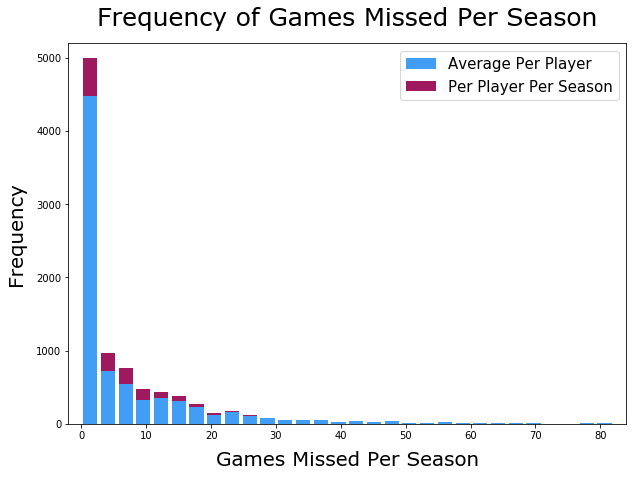

In [3]:
plt.figure(figsize=(10,7))
plt.xlim(-2, 84)
plt.ylim(0, 5200)
plt.title('Frequency of Games Missed Per Season', size=25, fontname='Verdana', y=1.03)
plt.xlabel('Games Missed Per Season', size=20, fontname='Verdana', labelpad=10)
plt.ylabel('Frequency', size=20, fontname='Verdana', labelpad=10)
plt.hist([rolling_df['Games_Missed'], player_df['Games_Missed']],
         bins=30,
         color=['#429ef4', '#9e195d'],
         rwidth=.8,
         histtype='barstacked')
plt.legend(['Average Per Player', 'Per Player Per Season'],
           fontsize=15);

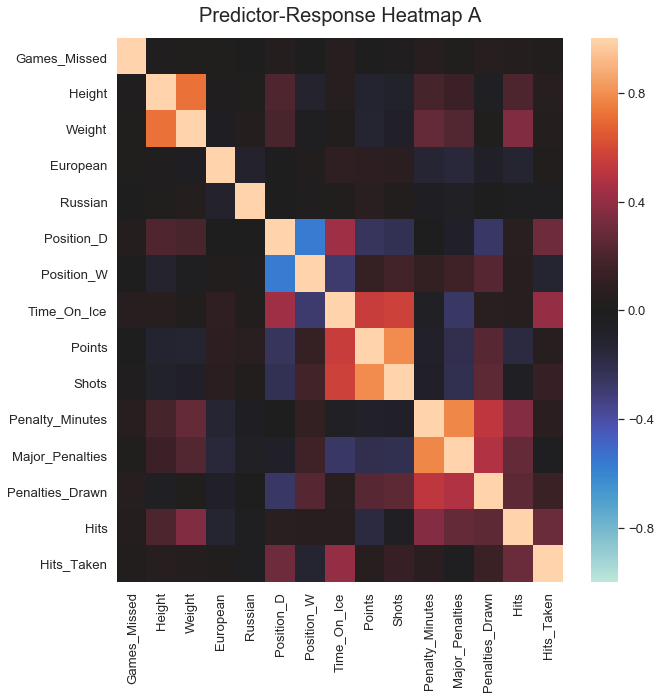

In [4]:
dummies_df = pd.get_dummies(rolling_df, drop_first=True)
cols1 = ['Games_Missed', 'Height', 'Weight', 'European', 'Russian', 'Position_D', 'Position_W',
         'Time_On_Ice', 'Points', 'Shots', 'Penalty_Minutes', 'Major_Penalties', 'Penalties_Drawn',
         'Hits', 'Hits_Taken']
cols2 = ['Games_Missed', 'Shots_Blocked', 'Age', 'Last_Games_Missed', 'Avg_Games_Missed',
         'Avg_Games_Played', 'Avg_Time_On_Ice', 'Avg_Points', 'Avg_Shots', 'Avg_Penalty_Minutes',
         'Avg_Major_Penalties', 'Avg_Penalties_Drawn', 'Avg_Hits', 'Avg_Hits_Taken',
         'Avg_Shots_Blocked']

plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
plt.title('Predictor-Response Heatmap A', size=20, y=1.02)
sns.heatmap(dummies_df[cols1].corr(), cmap="icefire", annot=False, vmin=-1, vmax=1);

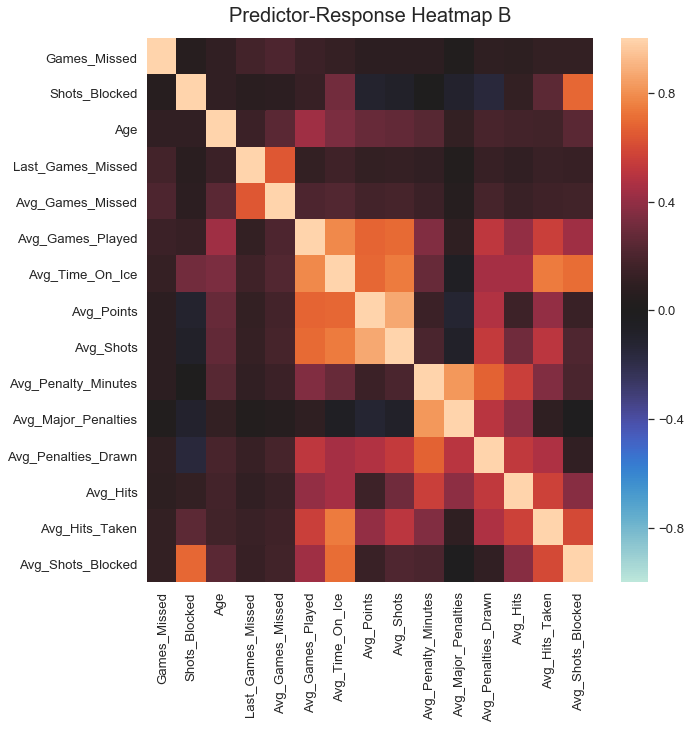

In [5]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
plt.title('Predictor-Response Heatmap B', size=20, y=1.02)
sns.heatmap(dummies_df[cols2].corr(), cmap="icefire", annot=False, vmin=-1, vmax=1);

### 4. Compare Linear and Lasso Models by DataFrame
Since all three DataFrames I made can be modeled in the same way, I wrote a function to iteratively compare their results. The purpose of this stop is not to build the final model, but to determine which data should be used to train the final model. I ran **compare_regressions** several times and chose to move forward with the Rolling Averages data based on the results since it returned similar test R<sup>2</sup> scores that were consistently the highest.

In [6]:
compare_regressions([season_df, player_df, rolling_df],
                    ['By Player-Season:', 'By Player Average Season:', 'By Rolling Average:'],
                    'Games_Missed')


By Player-Season:
- Linear Model:
    Train Score: 0.06012597116202134
    Test Score: 0.03696506866025184
- Lasso Model:
    Train Score: 0.07750372499724578
    Test Score: 0.060502048662226186

By Player Average Season:
- Linear Model:
    Train Score: 0.06217658447100515
    Test Score: 0.020642111532655272
- Lasso Model:
    Train Score: 0.08357253900561878
    Test Score: 0.029004636175105514

By Rolling Average:
- Linear Model:
    Train Score: 0.07173942231456876
    Test Score: 0.047892064262228584
- Lasso Model:
    Train Score: 0.11657065333421057
    Test Score: 0.06946741951164515


### 5. Build Final Model
While **compare_regressions** is useful for choosing the best data set, it is not suitable for building a final model because it does not separate out proper validation and test sets. Here I built a model using the optimal DataFrame determined be the previous step: **LassoCV** with **rolling_df**.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dummies_df.drop('Games_Missed', axis=1),
                                                    dummies_df['Games_Missed'],
                                                    test_size=0.1,
                                                    random_state=29)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=92)

# Standardize variables
scl = StandardScaler()
X_train_scl = scl.fit_transform(X_train.values)
X_val_scl = scl.transform(X_val.values)
X_test_scl = scl.transform(X_test.values)

# Train and test model
m = LassoCV(cv=5)
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train_scl), y_train)
print('Train Score:', m.score(p.transform(X_train_scl), y_train))
print('Validation Score:', m.score(p.transform(X_val_scl), y_val))

Train Score: 0.10700512809992359
Validation Score: 0.08254805551747013


### 6. Get Test Score


In [8]:
print('Test Score:', m.score(p.transform(X_test_scl), y_test))

Test Score: 0.07499376566880156


### 7. Compare Linear Model to Random Forest Model
I compared the error of my linear model to that of a random forest regression model to determine if my model's poor performance is primarily a result of linear regression not fitting the data well. Since the random forest model performed only marginally better I concluded that the features of my data likely do not predict the response very well.

In [9]:
mrf = RandomForestRegressor(n_estimators=40, min_samples_split=25)  
mrf.fit(X_train_scl, y_train)
print('Train Score:', mrf.score(X_train_scl, y_train))
print('Validation Score:', mrf.score(X_val_scl,y_val))
print('Test Score:', mrf.score(X_test_scl,y_test))

Train Score: 0.5540558821213651
Validation Score: 0.08033583600076444
Test Score: 0.10674840874698344


### 8. Calculate Mean Absolute Error
I calculated Mean Absolute Error to determine how far off my model will be in terms of games missed per season.

In [10]:
y_train_pred = m.predict(p.transform(X_train_scl))
y_val_pred = m.predict(p.transform(X_val_scl))
y_test_pred = m.predict(p.transform(X_test_scl))
print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))
print('Test MAE:', mean_absolute_error(y_test, y_test_pred))
print('Average Games Missed:', rolling_df['Games_Missed'].mean())

Train MAE: 7.570938467417531
Validation MAE: 7.6274343624249425
Test MAE: 7.583876224924709
Average Games Missed: 6.892115654056808


### 9. Find the Most Important Variables
Even though my model is not very useful for predictive purposes, it can glean some useful information in revealing which variables do have any predictive quality.

In [11]:
features = list(zip(m.coef_, p.get_feature_names(X_train.columns)))
features.sort(key=lambda x: abs(x[0]))
features = list(filter(lambda x: abs(x[0]) > .01, features))
values, names = zip(*features)
names = [name.replace(' ', ' x ').replace('Avg_', 'Avg_Prev_').replace('_', ' ') for name in names]

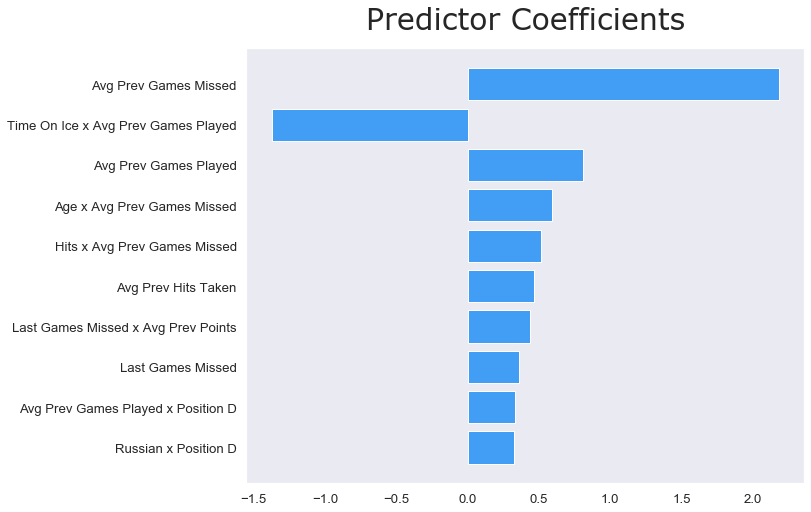

In [12]:
plt.figure(figsize=(10,8))
plt.title('Predictor Coefficients', size=30, fontname='Verdana', y=1.03)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.grid(False)
plt.barh(names[-10:], values[-10:], color='#429ef4');

**Average Previous Games Missed** and **Last Games Missed** are both metrics quantifying a player's past injuries and appear in half of the top ten predictor coefficients list, which lends some credence to 'injury prone' players being more likely to miss games due to injury in the future. A notable absence on the list is biometric predictors **height** and **weight**, meaning the model provides no evidence that differences in size contribute to games missed from injury.

### 10. Plot Residuals
I compared the residuals of the predictions from the linear model and the random forest model by plotting both. The scatter plots back up what the R<sup>2</sup> scores indicate: neither model is able to effectively predict the response.

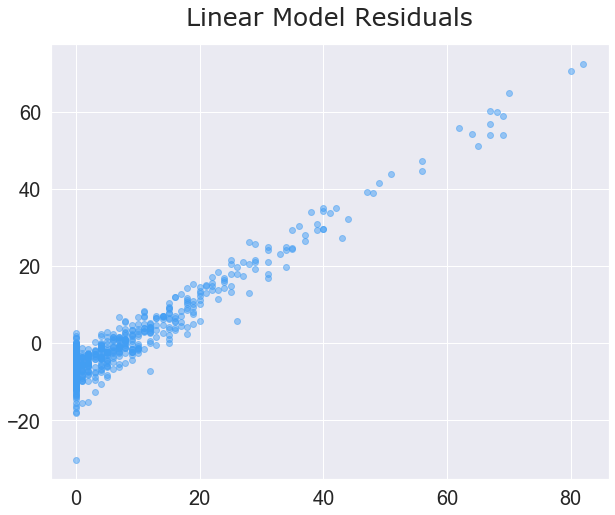

In [13]:
plt.figure(figsize=(10, 8))
plt.title('Linear Model Residuals', size=25, fontname='Verdana', y=1.03)
plt.scatter(y_test, y_test - y_test_pred, alpha=.5, color='#429ef4');

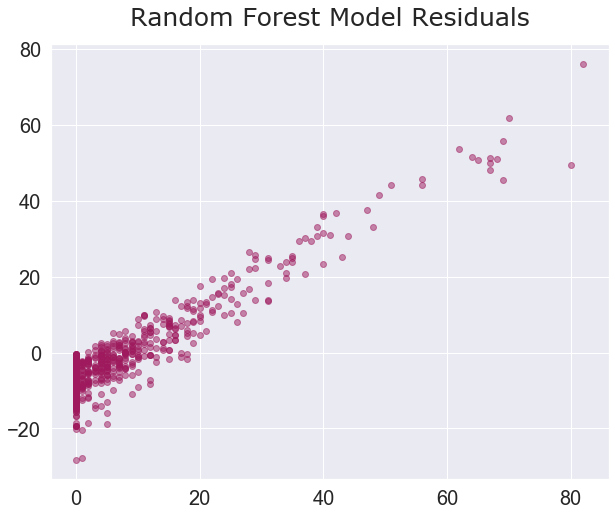

In [14]:
plt.figure(figsize=(10, 8))
plt.title('Random Forest Model Residuals', size=25, fontname='Verdana', y=1.03)
plt.scatter(y_test, y_test - mrf.predict(X_test_scl), alpha=.5, color='#9e195d');